<a href="https://colab.research.google.com/github/rebekap01/toxicity-detection/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Online Harassment and Toxicity Detection

* [0. Introduction](#scrollTo=WvAUAwO6MZIk)

* [1. Data Importing](#scrollTo=AYeA1-1Nh9Hd)

* [2. Data Cleaning](#scrollTo=ymzxQSdFiE1O)

* [3. Noise Generation](#scrollTo=2nxWAyirjJNy)

* [4. Tokenization](#scrollTo=14Z8YxVcGKTl)

* [5. Model Training](#scrollTo=Y7hKO7e3GPXf)

  - [5.1 Model 1 - Bidirectional RNN with LSTM trained on clean data](#scrollTo=ep7TxUOEU9wn)

  - [5.2 Model 2 - BERT model trained on clean data](#scrollTo=jyVPLHEfVQke)

  - [5.3 Model 3 - Bidirectional RNN with LSTM trained on 5% noisy data](#scrollTo=-Dt-UlKDVXjk)

  - [5.4 Model 4 - BERT model trained on 5% noisy data](#scrollTo=w8GvYinaVd45)

* [6. Model Evaluation](#scrollTo=dyaTbdAIeuEc)

* [7. Discussion](#scrollTo=_mpO-0vrOL1b)



## 0. Introduction <a class="anchor"  id="section0"></a>

The rise of online communication provides opportunities for sharing ideas and discussions. However, online communities have also become breeding grounds for toxic behavior, ranging from offensive language to hate speech and cyberbullying. This pervasive issue poses significant challenges to maintaining a safe and inclusive online environment.

Detecting toxic content in online conversations is crucial for mitigating its harmful impacts. Traditional methods for identifying toxic content rely on manually curated dictionaries of offensive words and phrases. However, this approach is often ineffective as users employ a variety of tactics to bypass these filters, such as using misspellings to disguise their toxic intentions.

A study done by Kurita, Belova & Anastasopoulos (2019) found that by using perturbations people were able to bypass automatic detectors with successrates of sometimes more than 50%. The study examined the effect of training on synthetically noised data and the use of a Contextual Denoising Autoencoder.

To address these bypass attempts, this project, inspired by Kurita et al. (2019) explores the effectiveness of two deep learning models, Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM) cells and Bidirectional Encoder Representations from Transformers (BERT). We propose a two-pronged approach: training the models on both unmodified data containing toxic comments and manipulated data that have been altered to evade detection. The strategy is to strengthen the models by making them more robust to different patterns of toxic language.

Our experiment reveals the relative effectiveness of RNNs with LSTMs and BERT under different training conditions in detecting toxic comments. We evaluate the models' performance on original and manipulated data, examining their ability to detect both overtly toxic instances as well more subtle ones. The findings of this project and others may be used to develop more advanced and robust learning algorithms for identifying toxic content within online communities, thereby creating a safer digital society.

The notebook is divided into the following main sub-sections:
1. Data Importing
2. Data Cleaning
3. Noise Generation
4. Tokenization
5. Model Training
6. Model Evaluation
7. Discussion


## 1. Data Importing <a class="anchor"  id="section1"></a>

The dataset used for this project is the Jigsaw Toxic Comment Classification Challenge dataset from Kaggle (cjadams et al., 2017), which is a large collection of 159,571 comments from Wikipedia's talk pages.

The dataset is organized into six toxicity categories: toxic, severe toxic, obscene, threat, insult, and identity hate. Each comment is labeled with one or more of these categories, indicating the type of toxicity that it exhibits, if at all (it contains a binary 0-1 score for each of the toxicity categories). The distribution of the labels is rather uneven, with 144,277 (90%) of the comments being non-toxic and 15,294 comments (10%) exhibiting some level of toxicity.

In this section, we import the necessary packages and load the data.

Note: a valid Kaggle user .json token is needed to be able to access the dataset directly from Kaggle.

In [ ]:
# Importing all necessary packages

from google.colab import files
import zipfile
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import sys
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import string
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Initializing kaggle configuration for download

! pip install -q kaggle

files.upload() # Upload Kaggle user's .json token file from account->settings->API->'create new token'

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Downloading dataset zip file

! kaggle datasets download -d julian3833/jigsaw-toxic-comment-classification-challenge -p '/content/'

jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzipping dataset files

with zipfile.ZipFile('/content/jigsaw-toxic-comment-classification-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
# Renaming dataset files

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
test_labels = pd.read_csv('/content/test_labels.csv')

train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## 2. Data Cleaning <a class="anchor"  id="section2"></a>

**Data cleaning**
In the cell below there is a function for cleaning the data. There are multiple actions being done that are being discussed here. Each of these actions aims at reducing noise and creating a sparse input for the model in order to increase robustness and improve training efficiency.

**Remove HTML/URL:** Some comments have some sort of hyperlink in them, usually referencing to other webpages for additional information. These links have no additional information in them that could be of any value for our semantic analysis.

**Remove non-text characters and extra whitespace:** This is a regular cleaning step and removes all non-text characters and extra whitespaces which obviously don’t hold any semantic information.

**Reduce consecutive occurrences:** There are no words in the English language that have three or more of the same consecutive character.

**Convert to lowercase:** The conversion from capitals to everything in lowercase has been proven to reduce the number of attributes significantly and improves classification accuracy.

**Remove punctuation and single characters:** Punctuation is convenient for language comprehension for humans but they do not represent any semantic information and thus can be removed.

**Expand contractions:** The expansion of contractions means that a word such as “don’t” gets converted to “do not”. This step could be seen as a form of standardizing and ensuring that negations are treated the same throughout the data.

**Separate numbers and symbols:** Numbers are not valuable for the semantic analysis. However, in the second part of the modelling there will be some vowels changed for numbers for exploratory purposes.

**Lemmatization:** This is the process reducing the words to their root and could be seen as a way to standardize words. For example, the words such as "runner", "running" and "ran" will all be reduced to their root, which is “change”. This helps to improve sparsity (Camacho-Collados & Pilehvar, 2017)

**Stemming:** This is a process which is very closely related to lemmatization but it uses heuristic rules to reduce words to their root form (Alnajran, Crockett, McLean & Latham, 2018). The difference is mainly that Lemmatization reduces words to their Lemma, which are always existing words since it uses a lexicon and stemming could also produce non-existing words.

**Remove emoticons/special characters:** Any character that is not an alphanumeric or whitespace character gets removed from the dataset since this has no semantic meaning.

We decided not to remove stopwords in our data cleaning since we believe using a pre-defined library of stopwords is overly simplistic as it could end up removing some words that are useful for our classification. The LSTM we used in our RNN model and the BERT model both have a method of focusing on what is important - forget gate in the former and attention in the latter. Therefore, they can decide based on the data whether certain stopwords are important for the classification and should be focused on or if they are not important and hence should be forgotten.

In [ ]:
# Cleaning test dataset

# Filtering out rows with label '-1' from test_labels and remove these rows from test
test_labels = test_labels[test_labels['toxic'] != -1]

test = test[test['id'].isin(test_labels['id'])]

# Accounting for an error where some rows in the 'test' dataset have 'id' values not present in the 'test_labels'
test_labels = test_labels[test_labels['id'].isin(test['id'])]

print(test_labels.head(10))
print(test.head(10)) # Ids of test and test labels aligned for target variable balues of 0/1

                  id  toxic  severe_toxic  obscene  threat  insult  \
5   0001ea8717f6de06      0             0        0       0       0   
7   000247e83dcc1211      0             0        0       0       0   
11  0002f87b16116a7f      0             0        0       0       0   
13  0003e1cccfd5a40a      0             0        0       0       0   
14  00059ace3e3e9a53      0             0        0       0       0   
16  000663aff0fffc80      0             0        0       0       0   
17  000689dd34e20979      0             0        0       0       0   
19  000844b52dee5f3f      0             0        0       0       0   
21  00091c35fa9d0465      1             0        0       0       0   
22  000968ce11f5ee34      0             0        0       0       0   

    identity_hate  
5               0  
7               0  
11              0  
13              0  
14              0  
16              0  
17              0  
19              0  
21              0  
22              0  
         

Firstly, we classify the comments to fall into one of 3 categories: non-toxic (where none of the toxicity labels have a value of 1), toxic (where the comment has a positive value 1 for 'toxic', but not for any other label) and highly toxic (where the comment scores positively for toxic and insult and obscene). We have made this choice to simplify the categories, especially given the low percentage of toxic comments compared to non-toxic. The choice of labels used to define the highly labeled comments was subjectively made by us, we assume that these comments, since they have scored positively on several of the labels, present comment which is more toxic than a comment which has not been given a positive score of 'insult' or 'obscene'. The specific combination was made by the relatively high percentage (compared to other combinations of labels) of comments falling into this category. As such, we create a 'toxicity' output variable with ordinary values 0 for non-toxic, 1 for toxic and 2 for highly toxic comments.

In [ ]:
#Toxicity classification: non-toxic, toxic, highly toxic

# Train
train['toxicity'] = train.apply(lambda row: 2 if (row['toxic'] == 1) and (row['insult'] == 1) and (row['obscene'] == 1)
                    else (1 if row['toxic'] == 1
                           else 0), axis=1)
train = train[['id', 'comment_text', 'toxicity']]

# Test
test_labels['toxicity'] = test_labels.apply(lambda row: 2 if (row['toxic'] == 1) and (row['insult'] == 1) and (row['obscene'] == 1)
else (1 if row['toxic'] == 1 else 0), axis=1)
test_labels = test_labels[['id', 'toxicity']]

train.head(7)

,id,comment_text,toxicity
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,2


Secondly, we proceed to pre-process the data as specified in the beginning of this section.

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    # Removing HTML/URLs
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'http\S+', '', text)

    # Removing non-text characters and extra whitespace
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)

    # Reducing consecutive occurrences of three or more characters to just one
    text = re.sub(r'(\w)\1{2,}', r'\1', text)

    # Converting to lowercase
    text = text.lower()

    # Removing punctuation and single characters
    text = re.sub(r"[^\w\s\-]", "", text)
    text = re.sub(r"\s\-", " ", text)

    # Expanding contractions (incl. negations)
    text = re.sub(r"\b(?:\w+)'\b", "", text)

    # Separating numbers and symbols
    text = re.sub(r"([\d\-+\.]+)", r" \1 ", text)
    text = re.sub(r"([\!\"\#\$\%\^\&\*\(\)\-\+\.\;\:\'\/\<\>\?\@\_\{\|\}~]+)", r" \1 ", text)

    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Removing emoticons and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) if token is not None else '' for token in tokens]

    # Back to strings
    cleaned_text = ' '.join(tokens)

    return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Cleaning training and test datasets
train_clean = train
test_clean = test

tqdm.pandas()

train_clean['comment_text'] = train_clean['comment_text'].progress_apply(clean_text)

test_clean['comment_text'] = test_clean['comment_text'].progress_apply(clean_text)

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

## 3. Noise Generation <a class="anchor"  id="section3"></a>

In this section, we generate noisy versions of toxic comments by introducing subtle alterations to words within toxic comments, utilizing a list of the 700 most frequently occurring toxic words (we have defined toxic words as those which most highly appear in toxic comments compared to non-toxic comments). For 80% of toxic comments, the words that fall into this list are replaced with slightly modified versions of themselves, with the specific modifications involving replacing certain characters with numerical equivalents (e.g., 'i' with '1', 'a' with '@', 'u' with '*', etc.).

This section was inspired by the paper of Kurita et al. (2020), who created such an altered dataset, however, we have simplified their methods for the scope of this project, as well as adjusting the character modifications to only appear in toxic words – we reason that users are much more likely to censor offensive words than regular words, within a toxic comment, so, unlike the author’s suggestion of such a modification: “y0u are an 1d1ot”, which modifies the first and last word, we only apply modification to the last, toxic, word. We have made a choice to modify the vowel characters in words to maximize the possibility of a toxic word being modified by noise (we assume most words in the toxic-word-list contain a vowel).

The coding below first generates a top 700 toxic words list, defines function for adding noise to toxic words for 80% of comments and applies the function to copies of the training and test sets to create new, noisy, training and test sets.


In [ ]:
## Generating Top 700 Toxic Words List

# Separating, fitting and calculating word frequencies in toxic and non-toxic sentences
toxic_sentences = train_clean[train_clean['toxicity'] != 0]['comment_text']
non_toxic_sentences = train_clean[train_clean['toxicity'] == 0]['comment_text']

vectorizer = CountVectorizer()

toxic_sentence_matrix = vectorizer.fit_transform(toxic_sentences)

non_toxic_sentence_matrix = vectorizer.transform(non_toxic_sentences)

toxic_word_frequencies = toxic_sentence_matrix.sum(axis=0)
non_toxic_word_frequencies = non_toxic_sentence_matrix.sum(axis=0)

word_freq_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'toxic_frequency': toxic_word_frequencies.A[0],
    'non_toxic_frequency': non_toxic_word_frequencies.A[0]
})

# Difference in frequencies (toxic - non-toxic) as measure
word_freq_df['frequency_difference'] = word_freq_df['toxic_frequency'] - word_freq_df['non_toxic_frequency']

most_toxic_words = word_freq_df.sort_values(by='frequency_difference', ascending=False).head(700)

top_toxic_words = most_toxic_words['word'].tolist() #transform to list


print(top_toxic_words[:10]) #most toxic 10 words
print(top_toxic_words[-30:]) #most toxic last 30 words

['fuck', 'suck', 'shit', 'nigger', 'faggot', 'as', 'moron', 'fat', 'cunt', 'gay']
['ryanpostlethwait', 'ebusi', 'wikipediadestroy', 'roker', 'dbag', 'bhadva', '1737178250', 'himim', 'runt', 'eatin', 'jujub', 'makin', 'godforsaken', 'editorfag', '12210614163', 'qld', 'cacknuck', 'exmoor', 'foulmouth', 'jakeyboy', 'quah', 'smokin', 'stupi', 'shitt', 'popsuck', 'asswhip', 'tch', 'zod', 'sucki', '1732391762']


In [ ]:
# Function for adding noise to 80% of comments' words is word in top_toxic_words

def add_noise_toxic(text, toxic, seed=None):  # Optional set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    noisy_text = ""
    words = text.split()

    if toxic != 0 and np.random.rand() < 0.8:  # Perturbate 80% of toxic comments
        for i, word in enumerate(words):
            if word.lower() in top_toxic_words:
                noisy_word = ""
                for char in word:
                    if char.lower() == 'i':
                        noisy_word += '1'
                    elif char.lower() == 'a':
                        noisy_word += '@'
                    elif char.lower() == 'u':
                        noisy_word += '*'
                    elif char.lower() == 'o':
                        noisy_word += '0'
                    elif char.lower() == 'e':
                        noisy_word += '3'
                    else:
                        noisy_word += char

                noisy_text += noisy_word
            else:
                noisy_text += word

            if i < len(words) - 1:
                noisy_text += ' '
    else:
        noisy_text = text

    return noisy_text


In [ ]:
# Testing the function on the first row of train_clean
example_row = train_clean.iloc[6].copy()  # Create a copy of the first row to avoid modifying the original DataFrame
example_row['comment_text'] = add_noise_toxic(example_row['comment_text'], toxic=example_row['toxicity'])

# Displaying the result
print(train_clean.iloc[6]['comment_text'])
print(example_row['comment_text'])

cocksuck befor you piss around on my work
c0cks*ck befor you p1ss around on my work


In [ ]:
# Noisy training and test datasets
tqdm.pandas()

train_noise = train_clean.copy()
test_noise = test_clean.copy()


# Assuming add_noise_toxic takes 'text' and 'toxic' arguments
train_noise['comment_text'] = train_clean.progress_apply(lambda row: add_noise_toxic(row['comment_text'], row.get('toxicity', 0)), axis=1)

test_noise['comment_text'] = test_clean.progress_apply(lambda row: add_noise_toxic(row['comment_text'], test_labels.loc[row.name, 'toxicity']), axis=1)


  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/63978 [00:00<?, ?it/s]

In [ ]:
# Checking whether training sets look the way we expect them to
print(train_clean["comment_text"].iloc[5:7])
print(train_noise["comment_text"].iloc[5:7])

5    congratul from me a well use the tool well talk
6          cocksuck befor you piss around on my work
Name: comment_text, dtype: object
5    congratul from me a well use the tool well talk
6          c0cks*ck befor you p1ss around on my work
Name: comment_text, dtype: object


In [ ]:
# Checking whether test sets look the way we expect them to
print(test_clean["comment_text"].tail(2))
print(test_noise["comment_text"].sample(10, random_state=2))

153155    mel gibson is a nazi bitch who make shitti mov...
153156    unicorn lair discoveri supposedli a unicorn la...
Name: comment_text, dtype: object
6493      request move gandzasar kapan fc the club offic...
3148                           hey @ssh0l show some respect
111204    im actual not oppos to to the articl say that ...
101271    pleas send a link of ani nation recogn the soc...
148079    syria mufti son wa assassin by arm oppositioni...
10449                   what state how mani is it just utah
126040    i convert the multipl imag into a galleri form...
19741     your comment give no guidanc on what you consi...
12272     coldplay page hello tbhotch thank for your wor...
83565     ie donald trump is an old toupeewear puritan p...
Name: comment_text, dtype: object


## 4. Tokenization <a class="anchor"  id="section4"></a>

In this section, we prepare the data, transforming its textual form into a format suitable for machine learning models. The preprocessing function ensures our text is in the adequate format for preprocessing, tokenizes using the 'Tokenizer' class to convert text into a sequence of tokens, representing individual words. This is done while limiting the vocabulary to be tokenized to the 10,000 most frequently occurring words to reduce dimensionality and computational complexity. Subsequently, the tokenized text is transformed into a numerical representation by assigning unique integer IDs to each token. Finally, pads are applied to the sequences to a fixed length of 128 tokens to ensure consistent input lengths for the models and the padded tokenized sequences are stored for later use.

In [ ]:
# Function to preprocess data
def preprocess_dataset(dataset):
    dataset['comment_text'] = dataset['comment_text'].astype(str)

    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(dataset['comment_text'])
    vocabulary_size = len(tokenizer.word_index) + 1
    sequences = tokenizer.texts_to_sequences(dataset['comment_text'])
    padded_sequences = pad_sequences(sequences, maxlen=128, padding='post', truncating='post')

    dataset['tokenized_sequences'] = padded_sequences.tolist()

    return dataset


# Preprocessing training and test sets for clean and noisy data
train_clean = preprocess_dataset(train_clean)
test_clean = preprocess_dataset(test_clean)
train_noise = preprocess_dataset(train_noise)
test_noise = preprocess_dataset(test_noise)

print(train_clean.head(2))
print(test_clean.head(2))

                 id                                       comment_text  \
0  0000997932d777bf  explan whi the edit made under my usernam hard...   
1  000103f0d9cfb60f  daww he match thi background colour im seeming...   

   toxicity                                tokenized_sequences  
0         0  [612, 83, 1, 32, 147, 203, 27, 659, 3752, 8189...  
1         0  [51, 1043, 14, 1321, 2228, 74, 3524, 2270, 21,...  
                 id                                       comment_text  \
5  0001ea8717f6de06  thank you for understand i think veri highli o...   
7  000247e83dcc1211                       dear god thi site is horribl   

                                 tokenized_sequences  
5  [67, 8, 12, 244, 7, 62, 121, 1163, 4, 8, 5, 43...  
7  [1326, 552, 13, 297, 6, 2260, 0, 0, 0, 0, 0, 0...  


## 5. Model Training <a class="anchor"  id="section5"></a>

We decided to investigate two models - a bidirectional recurrent neural network with long-term short-term memory and a BERT model. While the former has traditionally been the preferred way of handling textual data, the latter is a newer state-of-the-art method of dealing with text. Therefore, we were interested to see how the performance of these two models compared on our task. We also wanted to see how a model trained on the original (clean) data would generalize to the data set with added noise and how a model trained on the augmented (noisy) data would generalize to the original data set. Hence, we ended up with four models - an RNN trained on clean data, a BERT model trained on clean data, an RNN trained on nosiy data and a BERT model trained on noisy data.

We wanted to provide the models with a fair comparison, therefore, we kept many of the hyperparameter settings the same across the models. We also took inspiration for our hyperparameter settings from the ‘Towards Robust Toxic Content Classification’ paper by Kurita et al (2019) which deals with a very similar task to ours.

We decided to optimize the sparse categorical cross-entropy loss function since our categories are provided as integers rather than one-hot encodings. Additionally, we kept track of accuracy during training and validation for a quick evaluation of model performance and overfitting/underfitting.


Due to its shorter run time much of the hyperparameter experimentation was done on the RNN model. We realized that since our data set consists primarily of non-toxic comments and only of a very small percentage of toxic and highly toxic comments our models tended to get quite high accuracies but not learn much from the data. Therefore, in order to train useful toxicity classifiers we sampled the dataset so that each class was represented equally in the training set. We then adjusted the size of our validation set to more closely match the recommended proportions for training/validation sizes of 70/20.

Additionally, we noticed that our models tended to overfit the data since their validation accuracy did not monotonically increase over epochs. Hence, we implemented numerous mechanisms to combat this:
* **recurrent dropout** in the LSTM layer - ensures the model doesn't overly rely on specific sequences by randomly setting 20% of recurrent connections to 0,
* **L2 regularization** in the dense layer - discourages the model from learning overly complex patterns by adding a penalty to the loss function which punishes large weights,
* **reducing learning rate** if the validation loss plateaus - enables the model to take bigger steps when further away from the optimal loss and decrease these steps as it gets closer to not overshoot the minimum point,
* **early stopping** if the validation loss is not improving - stops the model from further training if this is no longer improving the validation loss.

 Despite these efforts, the validation accuracy still does not always monotonically increase across epochs for all of the models but it does abide by that general trend as can be seen in the line graphs below.

### 5.1 Model 1 - Bidirectional RNN with LSTM trained on clean data <a class="anchor"  id="section5.1"></a>

The architecture of our RNN model consists of:
 * an embedding layer which uses Xavier uniform initialization,
 * a bidirectional LSTM layer with recurrent dropout,
 * a 64-node dense layer with L2 regularization,
 * and a 3-node dense output layer with a softmax activation function.

In [ ]:
# Ensuring we can save the weights of the trained model for later
checkpoint_path = 'training_1.2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

vocabulary_size = 176469 + 1
embedding_dim = 200

# Training/Validation 80-20 split
X = train_clean[['id', 'comment_text', 'tokenized_sequences']]
y = train_clean['toxicity']
strat = train_clean['toxicity']

X_train, X_val_clean, y_train, y_val_clean = train_test_split(X, y, test_size=0.2,
                                                  stratify=strat,  # Validation contains same proportion of toxic as training
                                                  random_state=11)

# Creating a training set with equal number of data points from each class - oversampling of rare cases
selected_X0 = X_train['tokenized_sequences'].values[y_train == 0][:5000]
selected_X1 = X_train['tokenized_sequences'].values[y_train == 1][:5000]
selected_X2 = X_train['tokenized_sequences'].values[y_train == 2][:5000]
selected_X = np.append(selected_X0, selected_X1)
selected_X = np.append(selected_X, selected_X2)
selected_X = tf.ragged.constant(selected_X, dtype = tf.float32)

selected_y0 = y_train.values[y_train == 0][:5000]
selected_y1 = y_train.values[y_train == 1][:5000]
selected_y2 = y_train.values[y_train == 2][:5000]
selected_y = np.append(selected_y0, selected_y1)
selected_y = np.append(selected_y, selected_y2)
selected_y = tf.ragged.constant(selected_y, dtype = tf.float32)

# Selecting every 8th value from the validation set to make it proportional to the test set
X_val_clean_1 = tf.ragged.constant(X_val_clean['tokenized_sequences'][1::8], dtype=tf.float32)
y_val_clean_1 = y_val_clean.values[1::8]

# Building the model
model1 = tf.keras.Sequential([
    keras.layers.Embedding(input_dim = vocabulary_size, output_dim = embedding_dim, input_length = 128, embeddings_initializer = 'glorot_uniform'),
    keras.layers.Bidirectional(keras.layers.LSTM(16, activation = 'tanh', recurrent_dropout = 0.2)),
    keras.layers.Dense(64, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(3, activation = 'softmax')
])

# Reduce learning rate if the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Early stopping if the validation loss is not improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(1e-3), metrics = ['accuracy'])

# Fitting the model
model1.fit(x = selected_X, y = selected_y,
           epochs = 5, batch_size = 64,
           validation_data=(X_val_clean_1, y_val_clean_1), callbacks=[cp_callback, reduce_lr, early_stopping])

model1.save_weights(checkpoint_path.format(epoch=0))

# Downloading the last checkpoint from the Google Colab workspace onto the computer
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
files.download(latest_checkpoint + '.data-00000-of-00001')

Epoch 1/5
231/231 [==============================] - ETA: 0s - loss: 2.1486 - accuracy: 0.6451
Epoch 1: saving model to training_1.2/cp-0001.ckpt
231/231 [==============================] - 220s 915ms/step - loss: 2.1486 - accuracy: 0.6451 - val_loss: 0.6425 - val_accuracy: 0.8744 - lr: 0.0010
Epoch 2/5
231/231 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.7905
Epoch 2: saving model to training_1.2/cp-0002.ckpt
231/231 [==============================] - 198s 856ms/step - loss: 0.6159 - accuracy: 0.7905 - val_loss: 0.3535 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 3/5
231/231 [==============================] - ETA: 0s - loss: 0.4653 - accuracy: 0.8393
Epoch 3: saving model to training_1.2/cp-0003.ckpt
231/231 [==============================] - 203s 878ms/step - loss: 0.4653 - accuracy: 0.8393 - val_loss: 0.3260 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 4/5
231/231 [==============================] - ETA: 0s - loss: 0.3981 - accuracy: 0.8661
Epoch 4: saving model t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting the architecture of the model
plot_model(model1, to_file = 'model1_plot.png',
           show_shapes = True,
           show_layer_names = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

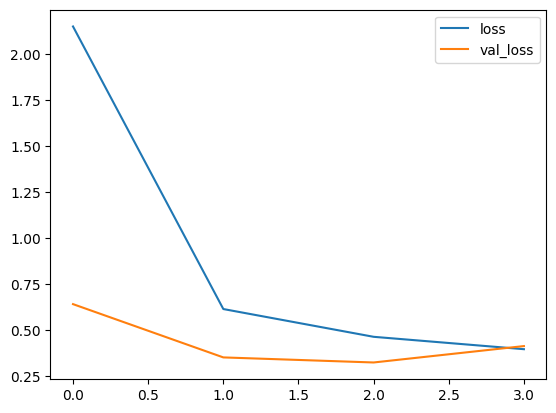

In [ ]:
# Visualizing the training and validation loss of the model
pd.DataFrame(model1.history.history)[['loss','val_loss']].plot()

# Saving the graph as a PNG
plt.savefig('clean_rnn_losses.png')
files.download('clean_rnn_losses.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

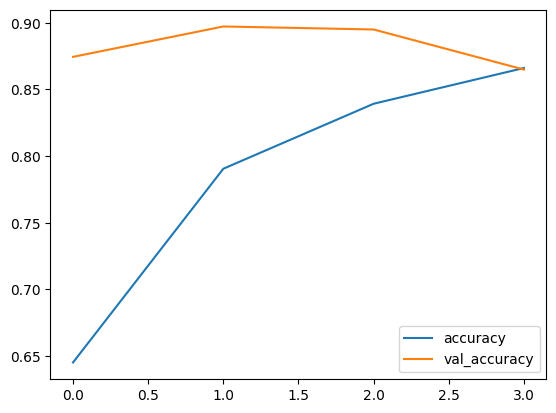

In [ ]:
# Visualizing the training and validation accuracy of the model
pd.DataFrame(model1.history.history)[['accuracy','val_accuracy']].plot()

# Saving the graph as a PNG
plt.savefig('clean_rnn_accuracies.png')
files.download('clean_rnn_accuracies.png')
plt.show()

The reason why in these plots we see a lower loss and higher accuracy for the validation set than the training set is that due to the dropout applied during training the model is not always able to use the optimal configuration of recurrent connections which is not the case during validation. Additionally, as we applied oversampling, the training set has an unnaturally high proportion of toxic and highly toxic comments while the validation set retains a real-world distribution of these categories.

### 5.2 Model 2 - BERT model trained on clean data <a class="anchor"  id="section5.2"></a>

The architecture of our BERT model consists of:
* an input layer,
* the pre-trained frozen BERT model for sequence classification,
* a 64-node dense layer,
* a max pooling layer,
* and a 3-node dense output layer with softmax activation.

In [ ]:
# Ensuring we can save the weights of the trained model for later
checkpoint_path = 'training_2.2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_model.trainable = False

# Creating a function for tokenizing and preparing the input data
def prepare_input_data(texts, max_length=128):
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        token_type_ids.append(encoded['token_type_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.concatenate(input_ids, axis = 0), np.concatenate(attention_masks, axis = 0), np.concatenate(token_type_ids, axis=0)

max_length = 128
# Creating a training set with equal number of data points from each class - oversampling of rare cases
selected_X0 = train_clean['comment_text'].loc[train_clean['toxicity'] == 0][:5000]
selected_X1 = train_clean['comment_text'].loc[train_clean['toxicity'] == 1][:5000]
selected_X2 = train_clean['comment_text'].loc[train_clean['toxicity'] == 2][:5000]
selected_X = np.append(selected_X0, selected_X1)
selected_X = np.append(selected_X, selected_X2)
train_input_ids, train_attention_masks, train_token_type_ids = prepare_input_data(selected_X.tolist(), max_length)

selected_y0 = train_clean.loc[train_clean['toxicity'] == 0, 'toxicity'][:5000]
selected_y1 = train_clean.loc[train_clean['toxicity'] == 1, 'toxicity'][:5000]
selected_y2 = train_clean.loc[train_clean['toxicity'] == 2, 'toxicity'][:5000]
selected_y = np.append(selected_y0, selected_y1)
selected_y = np.append(selected_y, selected_y2)
train_labels = tf.convert_to_tensor(selected_y, dtype = tf.float32)

# Selecting every 8th value from the validation set to make it proportional to the test set
val_input_ids, val_attention_masks, val_token_type_ids = prepare_input_data(X_val_clean['comment_text'].iloc[1::8].tolist(), max_length)
val_labels = tf.convert_to_tensor(y_val_clean.iloc[1::8].to_numpy(), dtype=tf.float32)

# Building the model
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')
token_type_ids = Input(shape=(max_length,), dtype='int32', name='token_type_ids')

bert_output = bert_model.bert(input_ids, attention_masks, token_type_ids)[0]
dense_layer = Dense(64, activation='relu')(bert_output)
max_pool = GlobalMaxPooling1D()(dense_layer)
output_layer = Dense(3, activation='softmax')(max_pool)

# Reduce learning rate if the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Early stopping if the validation loss is not improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model2 = Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output_layer)

model2.save_weights(checkpoint_path.format(epoch=0))

model2.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
model2.fit(
    x=[train_input_ids, train_attention_masks, train_token_type_ids],
    y=train_labels,
    epochs=4,
    batch_size=32,
    validation_data=([val_input_ids, val_attention_masks, val_token_type_ids], val_labels),
    callbacks=[cp_callback, reduce_lr, early_stopping]
)

# Downloading the last checkpoint from the Google Colab workspace onto the computer
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
files.download(latest_checkpoint + '.data-00000-of-00001')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
469/469 [==============================] - ETA: 0s - loss: 1.0869 - accuracy: 0.4681
Epoch 1: saving model to training_2.2/cp-0001.ckpt
469/469 [==============================] - 195s 388ms/step - loss: 1.0869 - accuracy: 0.4681 - val_loss: 0.7860 - val_accuracy: 0.6922 - lr: 3.0000e-05
Epoch 2/4
469/469 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.6011
Epoch 2: saving model to training_2.2/cp-0002.ckpt
469/469 [==============================] - 191s 408ms/step - loss: 0.8377 - accuracy: 0.6011 - val_loss: 0.6262 - val_accuracy: 0.7637 - lr: 3.0000e-05
Epoch 3/4
469/469 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.6524
Epoch 3: saving model to training_2.2/cp-0003.ckpt
469/469 [==============================] - 186s 398ms/step - loss: 0.7528 - accuracy: 0.6524 - val_loss: 0.5454 - val_accuracy: 0.7960 - lr: 3.0000e-05
Epoch 4/4
469/469 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.6866
Epoch 4: sa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting the architecture of the model
plot_model(model2, to_file = 'model2_plot.png',
           show_shapes = True,
           show_layer_names = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

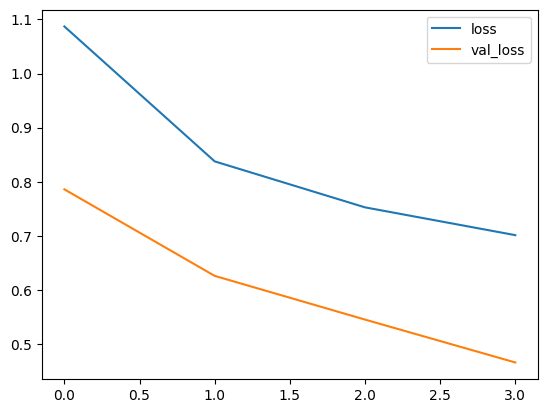

In [ ]:
# Visualizing the training and validation loss of the model
pd.DataFrame(model2.history.history)[['loss','val_loss']].plot()

# Saving the graph as a PNG
plt.savefig('clean_bert_losses.png')
files.download('clean_bert_losses.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

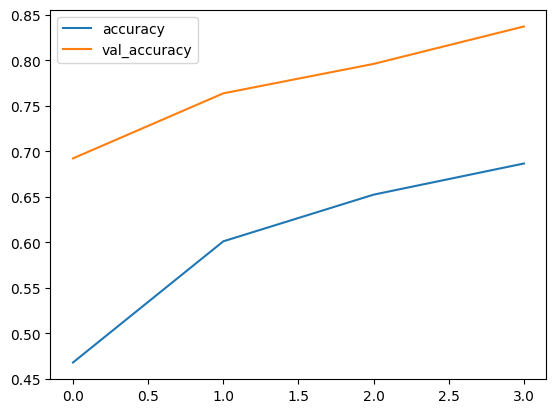

In [ ]:
# Visualizing the training and validation accuracy of the model
pd.DataFrame(model2.history.history)[['accuracy','val_accuracy']].plot()

# Saving the graph as a PNG
plt.savefig('clean_bert_accuracies.png')
files.download('clean_bert_accuracies.png')
plt.show()

### 5.3 Model 3 - Bidirectional RNN with LSTM trained on 5% noisy data <a class="anchor"  id="section5.3"></a>

The models trained on the noisy data copy the architecture of those trained of those trained on the clean data in order to allow for fair comparison of their performance.

In [ ]:
# Ensuring we can save the weights of the trained model for later
checkpoint_path = 'training_3.2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

vocabulary_size = 176469 + 1
embedding_dim = 200

# Training/Validation 80-20 split
X = train_noise[['id', 'comment_text', 'tokenized_sequences']]
y = train_noise['toxicity']
strat = train_noise['toxicity']

X_train_noise, X_val_noise, y_train_noise, y_val_noise = train_test_split(X, y, test_size=0.2,
                                                  stratify=strat,  # Validation contains same proportion of toxic as training
                                                  random_state=11)

# Creating a training set with equal number of data points from each class - oversampling of rare cases
selected_X0 = X_train_noise['tokenized_sequences'].values[y_train_noise == 0][:5000]
selected_X1 = X_train_noise['tokenized_sequences'].values[y_train_noise == 1][:5000]
selected_X2 = X_train_noise['tokenized_sequences'].values[y_train_noise == 2][:5000]
selected_X = np.append(selected_X0, selected_X1)
selected_X = np.append(selected_X, selected_X2)
selected_X = tf.ragged.constant(selected_X, dtype = tf.float32)

selected_y0 = y_train_noise.values[y_train_noise == 0][:5000]
selected_y1 = y_train_noise.values[y_train_noise == 1][:5000]
selected_y2 = y_train_noise.values[y_train_noise == 2][:5000]
selected_y = np.append(selected_y0, selected_y1)
selected_y = np.append(selected_y, selected_y2)
selected_y = tf.ragged.constant(selected_y, dtype = tf.float32)

# Selecting every 8th value from the validation set to make it proportional to the test set
X_val_noise_1 = tf.ragged.constant(X_val_noise["tokenized_sequences"][1::8], dtype=tf.float32)
y_val_noise_1 = y_val_noise.values[1::8]

# Building the model
model3 = tf.keras.Sequential([
    keras.layers.Embedding(input_dim = vocabulary_size, output_dim = embedding_dim, input_length = 128, embeddings_initializer = 'glorot_uniform'),
    keras.layers.Bidirectional(keras.layers.LSTM(16, activation = 'tanh', recurrent_dropout = 0.2)),
    keras.layers.Dense(64, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dense(3, activation = 'softmax')
])

# Reduce learning rate if the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Early stopping if the validation loss is not improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model3.save_weights(checkpoint_path.format(epoch=0))

model3.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(1e-3), metrics = ['accuracy'])

# Fitting the model
model3.fit(selected_X, selected_y,
           epochs = 5, batch_size = 64,
           validation_data=(X_val_noise_1, y_val_noise_1), callbacks=[cp_callback, reduce_lr, early_stopping])

# Downloading the last checkpoint from the Google Colab workspace onto the computer
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
files.download(latest_checkpoint + '.data-00000-of-00001')

Epoch 1/5
231/231 [==============================] - ETA: 0s - loss: 2.1253 - accuracy: 0.6686
Epoch 1: saving model to training_3.2/cp-0001.ckpt
231/231 [==============================] - 211s 891ms/step - loss: 2.1253 - accuracy: 0.6686 - val_loss: 0.6627 - val_accuracy: 0.8386 - lr: 0.0010
Epoch 2/5
231/231 [==============================] - ETA: 0s - loss: 0.5824 - accuracy: 0.8015
Epoch 2: saving model to training_3.2/cp-0002.ckpt
231/231 [==============================] - 195s 846ms/step - loss: 0.5824 - accuracy: 0.8015 - val_loss: 0.3831 - val_accuracy: 0.8662 - lr: 0.0010
Epoch 3/5
231/231 [==============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8264
Epoch 3: saving model to training_3.2/cp-0003.ckpt
231/231 [==============================] - 198s 856ms/step - loss: 0.4795 - accuracy: 0.8264 - val_loss: 0.4054 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 4/5
231/231 [==============================] - ETA: 0s - loss: 0.3970 - accuracy: 0.8653
Epoch 4: saving model t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

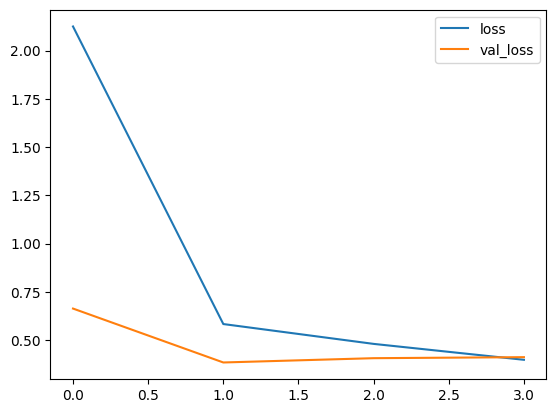

In [ ]:
# Visualizing the training and validation loss of the model
pd.DataFrame(model3.history.history)[['loss','val_loss']].plot()

# Saving the graph as a PNG
plt.savefig('noisy_rnn_losses.png')
files.download('noisy_rnn_losses.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

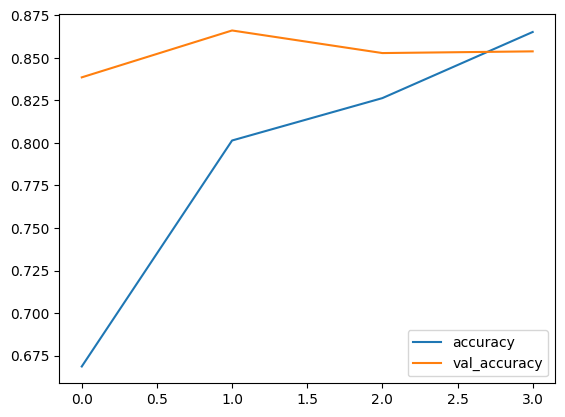

In [ ]:
# Visualizing the training and validation accuracy of the model
pd.DataFrame(model3.history.history)[['accuracy','val_accuracy']].plot()

# Saving the graph as a PNG
plt.savefig('noisy_rnn_accuracies.png')
files.download('noisy_rnn_accuracies.png')
plt.show()

### 5.4 Model 4 - BERT model trained on 5% noisy data <a class="anchor"  id="section5.4"></a>



In [ ]:
# Ensuring we can save the weights of the trained model for later
checkpoint_path = 'training_4.2/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
bert_model.trainable = False

max_length = 128
# Creating a training set with equal number of data points from each class - oversampling of rare cases
selected_X0 = train_noise['comment_text'].loc[train_noise['toxicity'] == 0][:5000]
selected_X1 = train_noise['comment_text'].loc[train_noise['toxicity'] == 1][:5000]
selected_X2 = train_noise['comment_text'].loc[train_noise['toxicity'] == 2][:5000]
selected_X = np.append(selected_X0, selected_X1)
selected_X = np.append(selected_X, selected_X2)
train_input_ids, train_attention_masks, train_token_type_ids = prepare_input_data(selected_X.tolist(), max_length)

selected_y0 = train_noise.loc[train_noise['toxicity'] == 0, 'toxicity'][:5000]
selected_y1 = train_noise.loc[train_noise['toxicity'] == 1, 'toxicity'][:5000]
selected_y2 = train_noise.loc[train_noise['toxicity'] == 2, 'toxicity'][:5000]
selected_y = np.append(selected_y0, selected_y1)
selected_y = np.append(selected_y, selected_y2)
train_labels = tf.convert_to_tensor(selected_y, dtype = tf.float32)

# Selecting every 8th value from the validation set to make it proportional to the test set
val_input_ids, val_attention_masks, val_token_type_ids = prepare_input_data(X_val_noise['comment_text'].iloc[1::8].tolist(), max_length)
val_labels = tf.convert_to_tensor(y_val_noise.iloc[1::8].to_numpy(), dtype=tf.float32)

# Building the model
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')
token_type_ids = Input(shape=(max_length,), dtype='int32', name='token_type_ids')

bert_output = bert_model.bert(input_ids, attention_masks, token_type_ids)[0]
dense_layer = Dense(64, activation='relu')(bert_output)
max_pool = GlobalMaxPooling1D()(dense_layer)
output_layer = Dense(3, activation='sigmoid')(max_pool)

model4 = Model(inputs=[input_ids, attention_masks, token_type_ids], outputs=output_layer)

model4.save_weights(checkpoint_path.format(epoch=0))

# Reduce learning rate if the validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)

# Early stopping if the validation loss is not improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

model4.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fitting the model
model4.fit(
    x=[train_input_ids, train_attention_masks, train_token_type_ids],
    y=train_labels,
    epochs=4,
    batch_size=32,
    validation_data=([val_input_ids, val_attention_masks, val_token_type_ids], val_labels),
    callbacks=[cp_callback, reduce_lr, early_stopping]
)

# Downloading the last checkpoint from the Google Colab workspace onto the computer
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
files.download(latest_checkpoint + '.data-00000-of-00001')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
469/469 [==============================] - ETA: 0s - loss: 1.0865 - accuracy: 0.4718
Epoch 1: saving model to training_4.2/cp-0001.ckpt
469/469 [==============================] - 198s 395ms/step - loss: 1.0865 - accuracy: 0.4718 - val_loss: 0.7743 - val_accuracy: 0.7100 - lr: 3.0000e-05
Epoch 2/4
469/469 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.6258
Epoch 2: saving model to training_4.2/cp-0002.ckpt
469/469 [==============================] - 187s 398ms/step - loss: 0.8162 - accuracy: 0.6258 - val_loss: 0.6136 - val_accuracy: 0.7870 - lr: 3.0000e-05
Epoch 3/4
469/469 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.6743
Epoch 3: saving model to training_4.2/cp-0003.ckpt
469/469 [==============================] - 186s 397ms/step - loss: 0.7240 - accuracy: 0.6743 - val_loss: 0.5059 - val_accuracy: 0.8278 - lr: 3.0000e-05
Epoch 4/4
469/469 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.6999
Epoch 4: sa

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

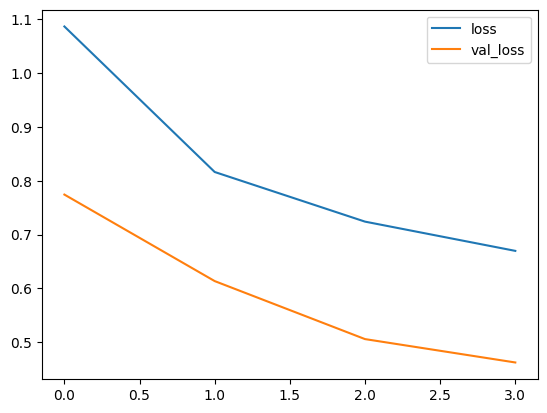

In [ ]:
# Visualizing the training and validation loss of the model
pd.DataFrame(model4.history.history)[['loss','val_loss']].plot()

# Saving the graph as a PNG
plt.savefig('noisy_bert_losses.png')
files.download('noisy_bert_losses.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

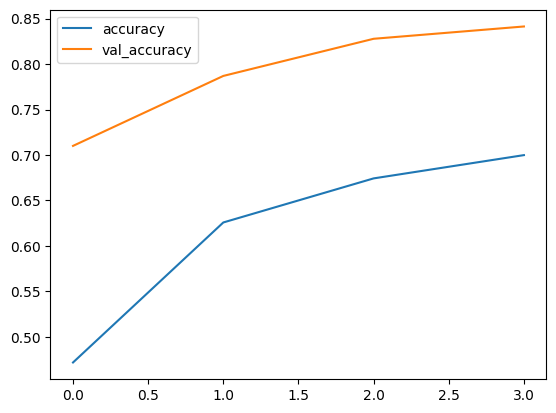

In [ ]:
# Visualizing the training and validation accuracy of the model
pd.DataFrame(model4.history.history)[['accuracy','val_accuracy']].plot()

# Saving the graph as a PNG
plt.savefig('noisy_bert_accuracies.png')
files.download('noisy_bert_accuracies.png')
plt.show()

## 6. Model Evaluation <a class="anchor"  id="section6"></a>

Since accuracy does not tend to be the most reliable metric when there is an unbalanced proportion of classes in the data set, we decided to also evaluate our models’ performance on the test set with precision, recall, and the F1-score. This provides us with a complex overview of the quality of our models and allows us to make better comparisons between them. We chose the F1 score as our key metric since it considers both false positives and false negatives, hence, providing a clear picture of model performance even in the case of inbalanced classes. For ease of comprehension, we also visualized this key metric for the different models in each category (non-toxic, toxic, and highly toxic) and on each data set (clean and noisy) using two bar graphs.

In [ ]:
test_clean = pd.merge(test_clean, test_labels, on='id', how='left')
test_noise = pd.merge(test_noise, test_labels, on='id', how='left')

# Preparing test_clean data for BERT
max_length = 128
test_input_ids, test_attention_masks, test_token_type_ids = prepare_input_data(test_clean['comment_text'].iloc[1::8].tolist(), max_length)
test_labels = tf.convert_to_tensor(test_clean.iloc[1::8, 3].to_numpy(), dtype=tf.float32)

# Preparing test_noise data for BERT
max_length = 128
ntest_input_ids, ntest_attention_masks, ntest_token_type_ids = prepare_input_data(test_noise['comment_text'].iloc[1::8].tolist(), max_length)
ntest_labels = tf.convert_to_tensor(test_noise.iloc[1::8, 3].to_numpy(), dtype=tf.float32)

In [ ]:
# Evaluate performance of Models 1-4 on clean data

## Model 1
print('Bidirectional RNN with LSTM trained on clean data, evaluated on clean data:')
y_test_1c = test_clean['toxicity'].values[1::8]
y_pred_1c = model1.predict(tf.ragged.constant(test_clean['tokenized_sequences'][1::8], dtype=tf.float32))
class_predictions_1c = np.argmax(y_pred_1c, axis=1)
print('Classification Report:')
print(classification_report(y_test_1c, class_predictions_1c))


## Model 2
print('BERT trained on clean data, evaluated on clean data:')
y_test_2c = test_labels
y_pred_2c = model2.predict([test_input_ids, test_attention_masks, test_token_type_ids])
class_predictions_2c = np.argmax(y_pred_2c, axis=1)
print('Classification Report:')
print(classification_report(y_test_2c, class_predictions_2c))

## Model 3
print('Bidirectional RNN with LSTM trained on noisy data, evaluated on clean data:')
y_test_3c = test_clean['toxicity'].values[1::8]
y_pred_3c = model3.predict(tf.ragged.constant(test_clean['tokenized_sequences'][1::8], dtype=tf.float32))
class_predictions_3c = np.argmax(y_pred_3c, axis=1)
print('Classification Report:')
print(classification_report(y_test_3c, class_predictions_3c))

## Model 4
print('BERT trained on noisy data, evaluated on clean data:')
y_test_4c = test_labels
y_pred_4c = model4.predict([test_input_ids, test_attention_masks, test_token_type_ids])
class_predictions_4c = np.argmax(y_pred_4c, axis=1)
print('Classification Report:')
print(classification_report(y_test_4c, class_predictions_4c))

Bidirectional RNN with LSTM trained on clean data, evaluated on clean data:
250/250 [==============================] - 28s 109ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      7228
           1       0.08      0.25      0.12       433
           2       0.08      0.07      0.07       337

    accuracy                           0.73      7998
   macro avg       0.36      0.37      0.35      7998
weighted avg       0.84      0.73      0.78      7998

BERT trained on clean data, evaluated on clean data:
Accuracy:
250/250 [==============================] - 74s 281ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89      7228
         1.0       0.16      0.45      0.23       433
         2.0       0.37      0.72      0.49       337

    accuracy                           0.80      7998
   macro avg       0.50      0.66      0.54   

In [ ]:
# Evaluate performance of Models 1-4 on 5% noisy data

## Model 1
print('Bidirectional RNN with LSTM trained on clean data, evaluated on noisy data:')
y_test_1n = test_noise['toxicity'].values[1::8]
y_pred_1n = model1.predict(tf.ragged.constant(test_noise['tokenized_sequences'][1::8], dtype=tf.float32))
class_predictions_1n = np.argmax(y_pred_1n, axis=1)
print('Classification Report:')
print(classification_report(y_test_1n, class_predictions_1n))


## Model 2
print('BERT trained on clean data, evaluated on noisy data:')
y_test_2n = ntest_labels
y_pred_2n = model2.predict([ntest_input_ids, ntest_attention_masks, ntest_token_type_ids])
class_predictions_2n = np.argmax(y_pred_2n, axis=1)
print('Classification Report:')
print(classification_report(y_test_2n, class_predictions_2n))

## Model 3
print('Bidirectional RNN with LSTM trained on noisy data, evaluated on noisy data:')
y_test_3n = test_noise['toxicity'].values[1::8]
y_pred_3n = model3.predict(tf.ragged.constant(test_noise['tokenized_sequences'][1::8], dtype=tf.float32))
class_predictions_3n = np.argmax(y_pred_3n, axis=1)
print('Classification Report:')
print(classification_report(y_test_3n, class_predictions_3n))

## Model 4
print('BERT trained on noisy data, evaluated on noisy data:')
y_test_4n = ntest_labels
y_pred_4n = model4.predict([ntest_input_ids, ntest_attention_masks, ntest_token_type_ids])
class_predictions_4n = np.argmax(y_pred_4n, axis=1)
print('Classification Report:')
print(classification_report(y_test_4n, class_predictions_4n))

Bidirectional RNN with LSTM trained on clean data, evaluated on noisy data:
Accuracy:
250/250 [==============================] - 100s 402ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      7228
           1       0.07      0.23      0.10       433
           2       0.03      0.03      0.03       337

    accuracy                           0.72      7998
   macro avg       0.34      0.35      0.32      7998
weighted avg       0.82      0.72      0.76      7998

BERT trained on clean data, evaluated on noisy data:
Accuracy:
250/250 [==============================] - 208s 833ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.89      7228
         1.0       0.13      0.38      0.20       433
         2.0       0.32      0.55      0.40       337

    accuracy                           0.79      7998
   macro avg       0.47      0.59 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

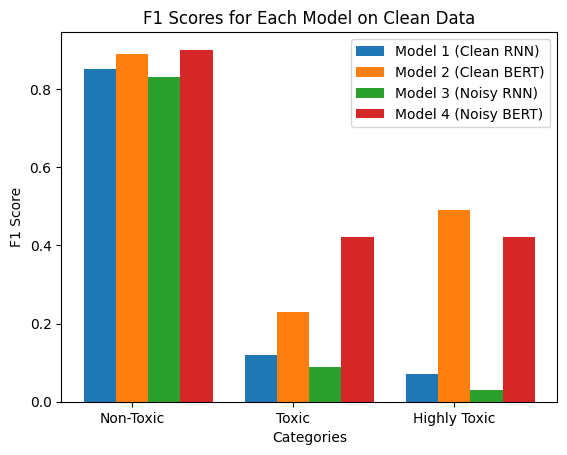

In [ ]:
non_toxic_f1 = [0.85, 0.89, 0.83, 0.90]
toxic_f1 = [0.12, 0.23, 0.09, 0.42]
highly_toxic_f1 = [0.07, 0.49, 0.03, 0.42]

# Creating a bar graph with F1 scores for each category and each model
models = ['Model 1 (Clean RNN)', 'Model 2 (Clean BERT)', 'Model 3 (Noisy RNN)', 'Model 4 (Noisy BERT)']
categories = ['Non-Toxic', 'Toxic', 'Highly Toxic']

bar_width = 0.2
bar_positions = np.arange(len(categories))

plt.bar(bar_positions - bar_width, [non_toxic_f1[0], toxic_f1[0], highly_toxic_f1[0]], width=bar_width, label=models[0])
plt.bar(bar_positions, [non_toxic_f1[1], toxic_f1[1], highly_toxic_f1[1]], width=bar_width, label=models[1])
plt.bar(bar_positions + bar_width, [non_toxic_f1[2], toxic_f1[2], highly_toxic_f1[2]], width=bar_width, label=models[2])
plt.bar(bar_positions + 2 * bar_width, [non_toxic_f1[3], toxic_f1[3], highly_toxic_f1[3]], width=bar_width, label=models[3])

plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Model on Clean Data')
plt.xticks(bar_positions, categories)
plt.legend()

# Saving the graph as a PNG
plt.savefig('category_f1_scores.png')
files.download('category_f1_scores.png')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

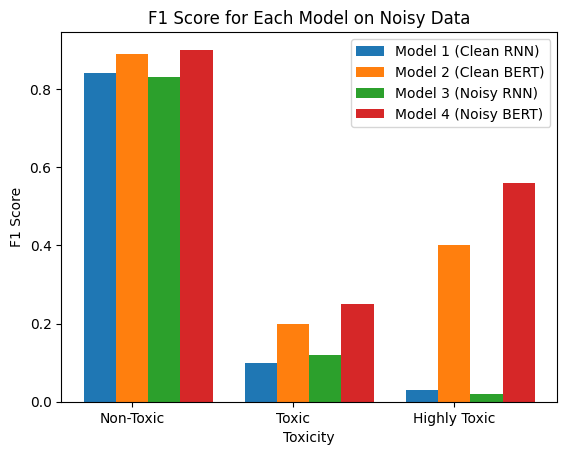

In [ ]:
# Creating a bar graph with per-category accuracies on noisy data for all models

model1_f1 = [0.84, 0.10, 0.03]
model2_f1 = [0.89, 0.20, 0.40]
model3_f1 = [0.83, 0.12, 0.02]
model4_f1 = [0.90, 0.25, 0.56]

models = ['Model 1 (Clean RNN)', 'Model 2 (Clean BERT)', 'Model 3 (Noisy RNN)', 'Model 4 (Noisy BERT)']
categories = ['Non-Toxic', 'Toxic', 'Highly Toxic']

bar_width = 0.2
bar_positions = np.arange(len(categories))

plt.bar(bar_positions - bar_width, model1_f1, width=bar_width, label = models[0])
plt.bar(bar_positions, model2_f1, width=bar_width, label = models[1])
plt.bar(bar_positions + bar_width, model3_f1, width=bar_width, label = models[2])
plt.bar(bar_positions + 2 * bar_width, model4_f1, width=bar_width, label = models[3])

plt.xlabel('Toxicity')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Model on Noisy Data')
plt.xticks(bar_positions, categories)
plt.legend()

# Saving the graph as a PNG
plt.savefig('noisy_data_f1.png')
files.download('noisy_data_f1.png')
plt.show()

**Results**

Noise-training improves BERT performance on noisy data (F1 = 0.56 vs 0.40 when trained on clean), while generalizing relatively well to clean data (F1 = 0.42). BERT performs significantly better than RNN at detecting toxicity. The F1-scores of all the models are still mainly supported by a high precision and recall for the majority (non-toxic) category. However, this is less so the case than when the models were being trained on an unbalanced dataset.

The RNN models are mostly good at predicting non-toxic comments and both their precision and recall fall as the toxicity of the comments increases. On the other hand, the BERT models have comparatively higher precision and recall for toxic and highly toxic comments. Surprisingly, they seem to be better at predicting highly toxic than toxic comments perhaps because of their greater distinction from non-toxic comments.

**Evaluation**

While BERT's performance improved on noisy data, the F1 statistic indicates that the model is roughly better than guessing. So while better than guessing the model is still likely to mislabel non-toxic comments as toxic and missing the actual toxic comments.

With regards to the noise inducement, it seems like the BERT model performs better with induced noise. With the addition of noise one would expect the prediction accuracy to decrease but this is not the case. One possible explanation for this is that the BERT is already pre-trained on a large database of text and that by inducing noise the model just learned some extra textual patterns.

## 7. Discussion <a class="anchor"  id="section7"></a>





**7.1 Generalizability**

Our dataset came from Wikipedia where the discussion differs from other social media in its topics which are more centered around the editing of the articles and the type of people that tend to participate which are mostly the article's editors. Therefore, the generalizability of our results to for example social media platforms, such as X or Instagram, is not certain and should be further investigated. The results are generalizable to discussions on open-source knowledge platforms.

**7.2 Opportunities for Improvement**

To improve the models could have been trained on naturally-occurring perturbed comments rather than manually-adjusted ones to more closely mimic comments in the real world. Additionally, with more time the models could be trained using more data which might particularly help improve the performance of the RNN models since they have not been pre-trained.

**7.3 Important Takeaways**

For platforms trying to tackle toxic comments, our project offers the solution of training a BERT model on noisy data to be able to counter perturbations as ways of bypassing current detection algorithms.
For researchers, our project opens up further avenues of research in toxic comment detection. For example, including spelling correction might further improve prediction accuracy as suggested by research in related areas (Setiabudi, Iswari & Rusli, 2021).

Eventually, it would be of interest to build a model that would be able to predict toxicity in whatever source is checked. In order to get to this level, the model should adapt Transfer Learning (TL). This is the process of enhancing the model’s ability to predict toxic comments in a target domain by using information from (different) source domains. These different source domains could then potentially include different kinds and levels of perturbations.


## Division of Labor

We divided the work in a way where each person was mainly in charge of one section and requested help from others in that section as needed. This ensured that everyone got to work on every section but also that there was someone who was primarily responsible for that section. The division was as follows:
*   **Rebeka Prívozníková:** model information, visualisation & model building
*   **Nina Dubicka:** introduction, noise generation & model building
*   **Bram Le Fèbre:** discussion, data cleaning & model building



## References

Alnajran, N., Crockett, K., McLean, D., & Latham, A. (2018). A Heuristic Based Pre-processing Methodology for Short Text Similarity Measures in Microblogs. 2018 IEEE 20th International Conference on High Performance Computing and Communications; *IEEE 16th International Conference on Smart City; IEEE 4th International Conference on Data Science and Systems (HPCC/SmartCity/DSS), pp. 1627-1633.* doi: 10.1109/HPCC/SmartCity/DSS.2018.00265

Camacho-Collados, J., & Pilehvar, M. T. (2017). On the Role of text preprocessing in Neural network architectures: An evaluation study on text categorization and sentiment analysis. *arXiv (Cornell University).* https://doi.org/10.48550/arxiv.1707.01780

HaCohen-Kerner, Y., Miller, D. C., & Yigal, Y. (2020). The influence of preprocessing on text classification using a bag-of-words representation. *PLOS ONE, 15(5), e0232525.* https://doi.org/10.1371/journal.pone.0232525

Kurita, K., Belova, A., & Anastasopoulos, A. (2019). Towards robust toxic content classification. *arXiv preprint arXiv:1912.06872.* doi: 10.48550/arXiv.1912.06872

Setiabudi, R., Iswari, N. M. S., & Rusli, A. (2021). Enhancing text classification performance by preprocessing misspelled words in Indonesian language. *TELKOMNIKA Telecommunication Computing Electronics and Control, 19(4), 1234.* https://doi.org/10.12928/telkomnika.v19i4.20369